<img src="diagrams/Its-never-too-late-for-change.png" alt="It's never too late to change" style="width:1000px;"/>
[Source: https://exceednutrition.com/wp-content/uploads/2015/04/Its-never-too-late-for-change..png]

# MLAI Session 7: Unsupervised Learning
## *Learning from unlabelled data*

### Haiping Lu -  COM4509/6509 MLAI2018 

### Based on slides by Neil D. Lawrence, Roger Grosse (Toronto) & Hong-yi Li (NTU, TW)

## Overview
### What happened last week

* Bayesian you, Bayesian me.
* The model - my belief of teaching is the **prior** [MLAI2015](https://github.com/lawrennd/mlai2015)
* The data - your response and your feedback are data giving the **likelihood**
* The model - I generalised and **marginalised** over model parameters (different ways of teaching), getting the **marginal likelihood**
* The model - I formed the **posterior** (belief after one week's observation / data), made the changes, which is this session

### What you will learn this week
* $k$-means **clustering**
* **Dimensionality reduction** - learning a latent, low-dimensional representation from unlabelled data
* Principal component analysis
* AutoEncoder, i.e., a standard unsupervised **Neural Network**, adapted from [TensorFlow Examples](https://github.com/aymericdamien/TensorFlow-Examples)

### Motivating Example: PCA without Math

[Watch: PCA main ideas in only 5 minutes](https://www.youtube.com/watch?v=HMOI_lkzW08)

### Unsupervised Learning

* Supervised learning is learning where each data point has a label (e.g. regression output)
* In unsupervised learning we have no labels for the data.
* Often thought of as structure discovery.
    * Finding features in the data
    * Exploratory data analysis
* In *Nature* 2015, <img src="https://static.oschina.net/uploads/space/2018/0324/203405_LC6Y_876354.png" alt="BigThreeDL" style="width:300px;"/> 
> We expect unsupervised learning to become far more important in the longer term. Human and animal learning is largely unsupervised: we discover the structure of the world by observing it, not by being told the name of every object!
    
## Clustering - $k$-means

* Associate each data point, $\mathbf{y}_{i, :}$ with one of $k$ different discrete groups.
* For example:
    * Clustering animals into discrete groups. Are animals discrete or continuous?
    * Clustering into different different *political* affiliations.
* **Question**: how to determine $k$?   

In [2]:
import pods
import mlai
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import *
def display_plots(filebase, directory=None, width=700, height=500, **kwargs):
    """Display a series of plots controlled by sliders. The function relies on Python string format functionality to index through a series of plots."""
    def show_figure(filebase, directory, **kwargs):
        """Helper function to load in the relevant plot for display."""
        filename = filebase.format(**kwargs)
        if directory is not None:
            filename = directory + '/' + filename           
        display(HTML("<img src='{filename}'>".format(filename=filename)))
        
    interact(show_figure, filebase=fixed(filebase), directory=fixed(directory), **kwargs)


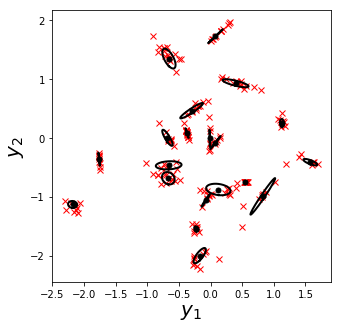

In [3]:
fig, ax = plt.subplots(figsize=(5,5))

num_centres = 20
num_data = 200
centres = np.random.normal(size=(num_centres, 2))
w = np.random.normal(size=(num_centres, 2))*0.1
alloc = np.random.randint(0, num_centres, size=(num_data))
sigma = np.random.normal(size=(num_centres, 1))*0.05
epsilon = np.random.normal(size=(num_data,2))*sigma[alloc, :]

Y = w[alloc, :]*np.random.normal(size=(num_data, 1)) + centres[alloc, :] + epsilon

ax.plot(Y[:, 0], Y[:, 1], 'rx')
ax.set_xlabel('$y_1$', fontsize=20)
ax.set_ylabel('$y_2$', fontsize=20)

plt.savefig('./diagrams/cluster_data00.svg')
pi_vals = np.linspace(-np.pi, np.pi, 200)[:, None]
for i in range(num_centres):
    ax.plot(centres[i, 0], centres[i, 1], 'o', markersize=5, color=[0, 0, 0], linewidth=2)
    x = np.hstack([np.sin(pi_vals), np.cos(pi_vals)])
    L = np.linalg.cholesky(np.outer(w[i, :],w[i, :]) + sigma[i]**2*np.eye(2))
    el = np.dot(x, L.T)
    ax.plot(centres[i, 0] + el[:, 0], centres[i, 1] + el[:, 1], linewidth=2, color=[0,0,0])
plt.savefig('./diagrams/cluster_data01.svg')    

In [4]:
display_plots('cluster_data{counter:0>2}.svg', directory='./diagrams', counter=(0, 1))


interactive(children=(IntSlider(value=0, description='counter', max=1), Output()), _dom_classes=('widget-inter…

### $k$-means Clustering

* Simple algorithm for allocating points to groups. 
* *Require*: Set $k$ and a stopping criterion
    1. Initialize cluster centres as randomly selected data points.
    2. Assign each data point to *nearest* cluster centre (centroid).
    3. Update each cluster centre by setting it to the mean of assigned data points.
    4. Repeat 2 and 3 until the stopping criterion reached (e.g., cluster allocations do not change).


### Objective Function

* This minimizes the objective (compactness)
  $$
    E=\sum_{j=1}^k \sum_{i\ \text{allocated to}\ j}  \left(\mathbf{y}_{i, :} - \boldsymbol{\mu}_{j, :}\right)^\top\left(\mathbf{y}_{i, :} - \boldsymbol{\mu}_{j, :}\right)
  $$
  *i.e.* it minimizes the sum of **Euclidean squared distances** betwen points and their associated centres.
* The minimum is *not* guaranteed to be *global* or *unique*.
* This objective is a non-convex optimization problem.
* **Question**: How to evaluate the clustering results?

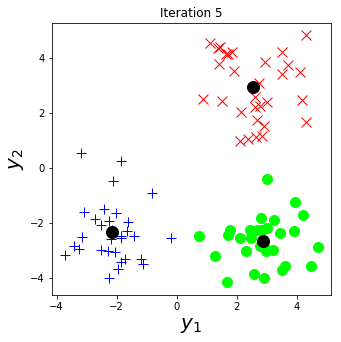

In [5]:
def write_plot(counter, caption):
    filebase = './diagrams/kmeans_clustering_{counter:0>3}'.format(counter=counter)
    plt.savefig(filebase + '.svg')
    f = open(filebase + '.tex', 'w')
    f.write(caption)
    f.close()
    
fig, ax = plt.subplots(figsize=(5,5))
fontsize = 20

num_clust_points = 30

Y = np.vstack([np.random.normal(size=(num_clust_points, 2)) + 2.5,
       np.random.normal(size=(num_clust_points, 2)) - 2.5,
       np.random.normal(size=(num_clust_points, 2)) + np.array([2.5, -2.5])])

centre_inds = np.random.permutation(Y.shape[0])[:3]
centres = Y[centre_inds, :]

ax.cla()

ax.plot(Y[:, 0], Y[:, 1], '.', color=[0, 0, 0], markersize=10)
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_title('Data')
counter=0
write_plot(counter, 'Data set to be analyzed. Initialize cluster centres.')
ax.plot(centres[:, 0], centres[:, 1], 'o', color=[0,0,0], linewidth=3, markersize=12)    
counter+=1
write_plot(counter, 'Allocate each point to the cluster with the nearest centre')
i = 0

for i in range(6):
    dist_mat = ((Y[:, :, None] - centres.T[None, :, :])**2).sum(1)
    ind = dist_mat.argmin(1)
    ax.cla()
    ax.plot(Y[ind==0, 0], Y[ind==0, 1], 'x', color= [1, 0, 0], markersize=10)
    ax.plot(Y[ind==1, 0], Y[ind==1, 1], 'o', color=[0, 1, 0], markersize=10)
    ax.plot(Y[ind==2, 0], Y[ind==2, 1], '+', color=[0, 0, 1], markersize=10)
    c = ax.plot(centres[:, 0], centres[:, 1], 'o', color=[0,0, 0], markersize=12, linewidth=3)
    ax.set_xlabel('$y_1$',fontsize=fontsize)
    ax.set_ylabel('$y_2$',fontsize=fontsize)
    ax.set_title('Iteration ' + str(i))
    counter+=1
    write_plot(counter, 'Update each centre by setting to the mean of the allocated points.')
    for j in range(centres.shape[0]):
          centres[j, :] = np.mean(Y[ind==j, :], 0)
    c[0].set_data(centres[:, 0], centres[:, 1])
    counter+=1
    plt.savefig('./diagrams/kmeans_clustering_{counter:0>3}.svg'.format(counter=counter))
    write_plot(counter, 'Allocate each data point to the nearest cluster centre.')




In [6]:
display_plots('kmeans_clustering_{counter:0>3}.svg', directory='./diagrams', 
                            text_top='kmeans_clustering_{counter:0>3}.tex', counter=(0, 13))

interactive(children=(Text(value='kmeans_clustering_{counter:0>3}.tex', description='text_top'), IntSlider(val…

## Dimensionality Reduction - PCA
### Motivation of Dimensionality Reduction: High Dimensional Data

* USPS Data Set Handwritten Digit
* 3648 dimensions (64 rows, 57 columns)
* Space contains much more than just this digit.
* **Question**: How many possible images of this size and bit depth?

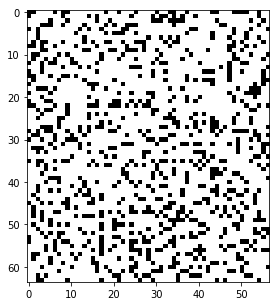

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

six_image = mlai.load_pgm('br1561_6.3.pgm', directory ='./diagrams')
rows = six_image.shape[0]
col = six_image.shape[1]
    
ax.imshow(six_image,interpolation='none').set_cmap('gray')
plt.savefig('./diagrams/dem_six000.png')
for i in range(3):
    rand_image = np.random.rand(rows, col)<((six_image>0).sum()/float(rows*col))
    ax.imshow(rand_image,interpolation='none').set_cmap('gray')
    plt.savefig('./diagrams/dem_six{i:0>3}.png'.format(i=i+1))    

In [10]:
display_plots('dem_six{counter:0>3}.png', directory='./diagrams', counter=(0, 3))

interactive(children=(IntSlider(value=1, description='counter', max=3), Output()), _dom_classes=('widget-inter…

### How About a Face?
<img src="diagrams/Subspace.png" alt="subspace" style="width:500px;"/>

### Low Dimensional Subspace/Manifolds

* For high dimensional data with *structure*:
    * We expect fewer variations than dimensions;
    * Therefore we expect the data to live on a lower dimensional manifold.
    * Conclusion: Deal with high dimensional data by looking for a lower dimensional embedding/projection/transformation.
    

### Principal Component Analysis

* PCA (@Hotelling:analysis33) is a linear embedding.
* Today its presented as:
    * Rotate to find 'directions' in data with maximal variance.
    * How do we find these directions?
* Algorithmically we do this by diagonalizing the **sample** covariance matrix (a.k.a. scatter matrix, related to correlated Gaussian section in Session 6, rotation matrix)
    $$
    \mathbf{S}=\frac{1}{n}\sum_{i=1}^n \left(\mathbf{y}_{i, :}-\boldsymbol{\mu}\right)\left(\mathbf{y}_{i, :} - \boldsymbol{\mu}\right)^\top
    $$
* **Interesting observation**: Compare this definition with the $k$-means objective function

### Principal Component Analysis

* Given data $\{\mathbf{y}\}$, PCA finds *orthogonal* directions defined by a projection $\mathbf{U}$ capturing the **maximum varience** in the data. The projected data (PCA representation) $\mathbf{x} = \mathbf{U}^\top\mathbf{y}$. Maximising the variance is equivalent to minimise the reconstruction error.
* **Question**: given the PCA representation $\mathbf{x}$, how to obtain (an approximation/reconstruction) of $\mathbf{y}$?

### Lagrangian

* Solution for the first direction is found via constrained optimisation (which uses [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier)): 
  $$
    L\left(\mathbf{u}_{1},\lambda_{1}\right)=\mathbf{u}_{1}^{\top}\mathbf{S}\mathbf{u}_{1}+\lambda_{1}\left(1-\mathbf{u}_{1}^{\top}\mathbf{u}_{1}\right)
  $$

* Gradient with respect to $\mathbf{u}_{1}$ 
  $$\frac{\text{d}L\left(\mathbf{u}_{1},\lambda_{1}\right)}{\text{d}\mathbf{u}_{1}}=2\mathbf{S}\mathbf{u}_{1}-2\lambda_{1}\mathbf{u}_{1}$$
rearrange to form
$$\mathbf{S}\mathbf{u}_{1}=\lambda_{1}\mathbf{u}_{1}.$$
  Which is known as an [*eigenvalue problem*](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors).
  
* Further directions that are *orthogonal* (uncorrelated) to the first can also be shown to be eigenvectors of the covariance.
* **Eigenvectors**: the *basis functions*, principal components
* **Eigenvalue**: the **variance** captured respectively.
* **Question**: What if further directions are not constrained to be orthogonal (do not have to be orthogonal to the first)?


  
### PCA for Visualisation

* A common way to visualise data is to plot PC1 vs PC2 (vs PC3)
* It is a fundamental method for visualisation, see [Google's Embedding projector using TensorFlow](https://projector.tensorflow.org/) with two default visualisation methods 1) PCA; 2) tSNE (have to use PCA as preprocessing for very big data). Go and play with it! You can play with your own data!
* Further reading: [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

## Neural Networks for Unsupervised Learning - AutoEncoder  (<span style="color:red">*optional*</span>)

### AutoEncoder
* AutoEncoder: a feed-forward neural network taking an input $\mathbf{x}$ and predict $\mathbf{x}$, i.e., reconstructing itself 
* To make this non-trivial, we need to add a bottleneck layer whose dimension is much smaller than the input, which is the latent representation of $\mathbf{x}$. [Representation Learning](https://en.wikipedia.org/wiki/Feature_learning)
<img src="https://cdn-images-1.medium.com/max/1600/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" alt="AE" style="width:500px;"/>


* Encoder: Learn a compact representation, the code, of the input data
* Decoder: Reconstruct the input data from the code

### PCA as Linear AutoEncoder
<img src="diagrams/PCA_as_AE.png" alt="PCA as AE.png" style="width:500px;"/>

* PCA can be view as a single-layer encoder, single-layer-decoder, AutoEncoder.
* AutoEncoder typically uses nonlinear functions, such as [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function)
* **Question**: If we stack multiple linear layers as the encoder, do we get a linear or nonlinear encoder?

### Deep AutoEncoder
<img src="diagrams/DeepAE.png" alt="Deep AE.png" style="width:500px;"/>

* Issues: architecture, optimisation (no closed-form solution as PCA), initialisation, computational time (many iterations), etc.

